In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import torch
import numpy as np
from models.ModularNetworks import PairwiseInteraction, Attention
from utils.es_utils_testing import *
from models.Buffer import Buffer
from models.PreyOnlyPolicy import PreyOnlyPolicy
from models.Discriminator import Discriminator

from utils.couzin_utils import *
from utils.sim_utils import *
mpl.use('TkAgg')
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
%matplotlib inline
from multiprocessing import Pool, set_start_method
from utils.train_utils import compute_wasserstein_loss, gradient_penalty
from torch.utils.data import TensorDataset, DataLoader, random_split

### Video Fish Trajectories

In [2]:
class Discriminator(nn.Module):
    def __init__(self, neigh=31, features=5):
        super(Discriminator, self).__init__()
        input_dim = neigh * features
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, tensor):
        batch, neigh, features = tensor.shape
        tensor = tensor.view(batch, neigh * features)
        params = torch.relu(self.fc1(tensor))
        params = torch.relu(self.fc2(params))
        params = self.fc3(params).squeeze(-1)
        return params # f(s,a): Wasserstein-Critic-Score (higher = closer to Expert)

    def update(self, expert_batch, policy_batch, optim_dis, lambda_gp, noise=0, generation=None, num_generations=None):
        if noise > 0.0:
            noise_until = 0.5 * num_generations
            decay = 1.0 - (generation / noise_until)
            decay = max(0.0, decay)
            noise_term = noise * decay

            exp_noise = torch.randn_like(expert_batch) * noise_term
            gen_noise = torch.randn_like(policy_batch) * noise_term

            # no noise on action
            exp_noise[..., 4] = 0.0
            gen_noise[..., 4] = 0.0

            expert_batch = expert_batch + exp_noise
            policy_batch = policy_batch + gen_noise

        exp_scores = self.forward(expert_batch)
        gen_scores = self.forward(policy_batch)
        
        grad_penalty = gradient_penalty(self, expert_batch, policy_batch)
        
        loss, loss_gp = compute_wasserstein_loss(exp_scores, gen_scores, lambda_gp, grad_penalty)
        
        optim_dis.zero_grad()
        loss_gp.backward()
        optim_dis.step()

        return {
            "dis_loss": round(loss.item(), 4),
            "dis_loss_gp": round(loss_gp.item(), 4),
            "grad_penalty": round(grad_penalty.item(), 4),
            "expert_score_mean": round(exp_scores.mean().item(), 4),
            "policy_score_mean": round(gen_scores.mean().item(), 4),
        }
    
    def set_parameters(self, init=True):
        if init is True:
            for layer in self.modules():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()

In [3]:
class ModularPolicy(nn.Module):
    def __init__(self, features=4):
        super(ModularPolicy, self).__init__()

        self.pairwise = PairwiseInteraction(features)
        self.attention = Attention(features)

    def forward(self, states, deterministic=True):
        mu, sigma = self.pairwise(states)

        weights_logit = self.attention(states)
        weights = torch.softmax(weights_logit, dim=1)

        if deterministic:
            scaled_action = torch.sigmoid(mu)
            action = (scaled_action * weights).sum(dim=1)
            return action
        else:
            action = Normal(mu, sigma).rsample()
            scaled_action = torch.sigmoid(action)
            action = (scaled_action * weights).sum(dim=1)
            return action
        
    def set_parameters(self, init=True):
        if init is True:
            for layer in self.modules():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()

In [4]:
def gradient_estimate(theta, rewards_norm, epsilons, sigma, lr, num_perturbations):
    grad = torch.zeros_like(theta)
    for eps, reward in zip(epsilons, rewards_norm):
        grad += eps * reward

    delta = (lr / (2 * sigma**2 * num_perturbations)) * grad

    theta_norm = theta.norm() + 1e-12
    max_delta_norm_rel = 0.01 * theta_norm

    max_delta_norm = torch.minimum(torch.tensor(0.1, device=theta.device, dtype=theta.dtype), max_delta_norm_rel)

    dn = delta.norm() + 1e-12
    if dn > max_delta_norm:
        delta = delta * (max_delta_norm / dn)

    return theta + delta


def discriminator_reward(discriminator, states, actions):
    _, neigh, _ = states.shape
    actions = actions.unsqueeze(1).expand(-1, neigh, -1)
    gen_states = torch.cat([states, actions], dim=-1)
    scores = discriminator(gen_states)
    return scores.mean()


def predict_actions(policy, states, determinstic):
    input = states[..., :4]
    actions = policy.forward(input, deterministic=determinstic)

    _, neigh, _ = input.shape
    actions = actions.unsqueeze(1).expand(-1, neigh, -1)
    tensor = torch.cat([input, actions], dim=-1)
    return tensor


def optimize_es(policy, module, discriminator, lr, sigma, num_perturbations, tensor, deterministic=True):

    network = policy.pairwise if module == 'pairwise' else policy.attention
    
    theta = nn.utils.parameters_to_vector(network.parameters()).detach().clone()
    dim = theta.numel()
    states = tensor[..., :4]

    reward_diffs = []
    epsilons = []

    for perturbation in range(num_perturbations):
        eps = torch.randn(dim, device=theta.device, dtype=theta.dtype) * sigma
        epsilons.append(eps)

        with torch.no_grad():
            nn.utils.vector_to_parameters(theta + eps, network.parameters())
            pos_actions = policy.forward(states, deterministic=deterministic)
            pos_reward = discriminator_reward(discriminator, states, pos_actions)

            nn.utils.vector_to_parameters(theta - eps, network.parameters())
            neg_actions = policy.forward(states, deterministic=deterministic)
            neg_reward = discriminator_reward(discriminator, states, neg_actions)

            nn.utils.vector_to_parameters(theta, network.parameters())

            reward_diffs.append((pos_reward.mean() - neg_reward.mean()).detach())

    diffs = torch.stack(reward_diffs)
    rewards_norm = (diffs - diffs.mean()) / (diffs.std(unbiased=False) + 1e-8)

    theta_est = gradient_estimate(theta, rewards_norm, epsilons, sigma, lr, num_perturbations)

    # if std is too small, do not update (Random Walk)
    if diffs.std(unbiased=False) < 1e-6:
        theta_est = theta
    nn.utils.vector_to_parameters(theta_est, network.parameters())
    
    return {
        "diff_min": round(diffs.min().item(), 6),
        "diff_max": round(diffs.max().item(), 6),
        "diff_mean": round(diffs.mean().item(), 6),
        "diff_std": round(diffs.std(unbiased=False).item(), 6),
        "delta_norm": round((theta_est - theta).norm().item(), 6),
    }

def mae_actions(expert_batch, generative_batch):
    a_exp = expert_batch[..., 4]
    a_gen = generative_batch[..., 4]
    return torch.mean(torch.abs(a_exp - a_gen)).item()


def convert_actions(buffer):
    buf = buffer.prey_buffer

    for i in range(len(buf)):
        states = buf[i]
        states[..., 4] = (states[..., 4] + 1.0) / 2.0
        buf[i] = states

In [5]:
def pretrain_policy(policy, buffer, batch_size=256, epochs=10, lr=1e-3, deterministic=True, device='cpu'):
    policy.to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        batch = buffer.sample(batch_size).to(device)
        states = batch[..., :4]                 # [B, 31, 4]

        actions = batch[:, 0, 4].unsqueeze(-1)  # [B, 1]

        action_prey = policy.forward(states, deterministic=deterministic)  # [B, 1]
        loss = F.mse_loss(action_prey, actions)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 25 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.6f}")

    return policy

In [ ]:
gamma = 0.999
sigma = 0.1
num_perturbations = 30
dis_balance_factor = 1

lr_policy = 0.001
lr_disc = 0.00005
lambda_gp = 10
deterministic=True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

expert_buffer = Buffer(prey_max_length=10000)
generative_buffer = Buffer(prey_max_length=10000)

traj_path = rf'..\data\1. Data Processing\processed\couzin\reversed'
expert_buffer.add_expert(traj_path)
convert_actions(expert_buffer)

policy = ModularPolicy().to(device)
pretrain_policy(policy, expert_buffer, batch_size=512, epochs=100, lr=1e-3, deterministic=deterministic, device=device)
print("Pretraining done.\n")

discriminator = Discriminator(neigh=32).to(device)
discriminator.set_parameters(init=True)
optim_dis_pred = torch.optim.RMSprop(discriminator.parameters(), lr=lr_disc, alpha=0.99, eps=1e-08)

maes_list = []
score_diffs = []
abs_scores = []

for gen in range(3000):

    for i in range(dis_balance_factor):
        expert_batch = expert_buffer.sample(1024).to(device)
        generative_batch = predict_actions(policy, expert_batch, deterministic)
        dis_metric = discriminator.update(expert_batch, generative_batch, optim_dis_pred, lambda_gp, noise=0.05, generation=gen, num_generations=2000)

    mae_val = mae_actions(expert_batch, generative_batch)
    maes_list.append(mae_val)

    pin_metrics = optimize_es(policy, "pairwise", discriminator, lr=lr_policy, sigma=sigma, num_perturbations=num_perturbations, tensor=expert_batch, deterministic=deterministic)
    an_metrics  = optimize_es(policy, "attention", discriminator, lr=lr_policy, sigma=sigma, num_perturbations=num_perturbations, tensor=expert_batch, deterministic=deterministic)

    sigma *= gamma
    lr_policy *= gamma

    if gen == 0:
        best_val = mae_val

    if mae_val < best_val:
        best_val = mae_val
        best_policy_state = policy.state_dict()
    
    score_diff = abs(dis_metric['expert_score_mean'] - dis_metric['policy_score_mean'])
    score_diffs.append(score_diff)
    abs_scores.append((dis_metric['expert_score_mean'], dis_metric['policy_score_mean']))

    print("Generation", gen)
    print(f"PIN Network:   {pin_metrics}")
    print(f"AN Network:    {an_metrics}")
    print(f"Discriminator: {dis_metric}")
    print(f"MAE: {mae_val} | Score Diff: {score_diff}\n")

policy.load_state_dict(best_policy_state)

Epoch 25/250, Loss: 0.085860
Epoch 50/250, Loss: 0.085319
Epoch 75/250, Loss: 0.044566
Epoch 100/250, Loss: 0.031151
Epoch 125/250, Loss: 0.025227
Epoch 150/250, Loss: 0.019970
Epoch 175/250, Loss: 0.022159
Epoch 200/250, Loss: 0.020316
Epoch 225/250, Loss: 0.012117
Epoch 250/250, Loss: 0.017061
Pretraining done.

Generation 0
PIN Network:   {'diff_min': -0.008744, 'diff_max': 0.018862, 'diff_mean': 0.003043, 'diff_std': 0.00739, 'delta_norm': 0.055796}
AN Network:    {'diff_min': -0.005727, 'diff_max': 0.007904, 'diff_mean': 0.000285, 'diff_std': 0.00381, 'delta_norm': 0.054402}
Discriminator: {'dis_loss': 0.0004, 'dis_loss_gp': 8.1262, 'grad_penalty': 0.8126, 'expert_score_mean': -0.0535, 'policy_score_mean': -0.0531}
MAE: 0.06896711885929108 | Score Diff: 0.0003999999999999976

Generation 1
PIN Network:   {'diff_min': -0.01507, 'diff_max': 0.020752, 'diff_mean': -0.001137, 'diff_std': 0.008642, 'delta_norm': 0.054614}
AN Network:    {'diff_min': -0.009519, 'diff_max': 0.009166, 'dif

<All keys matched successfully>

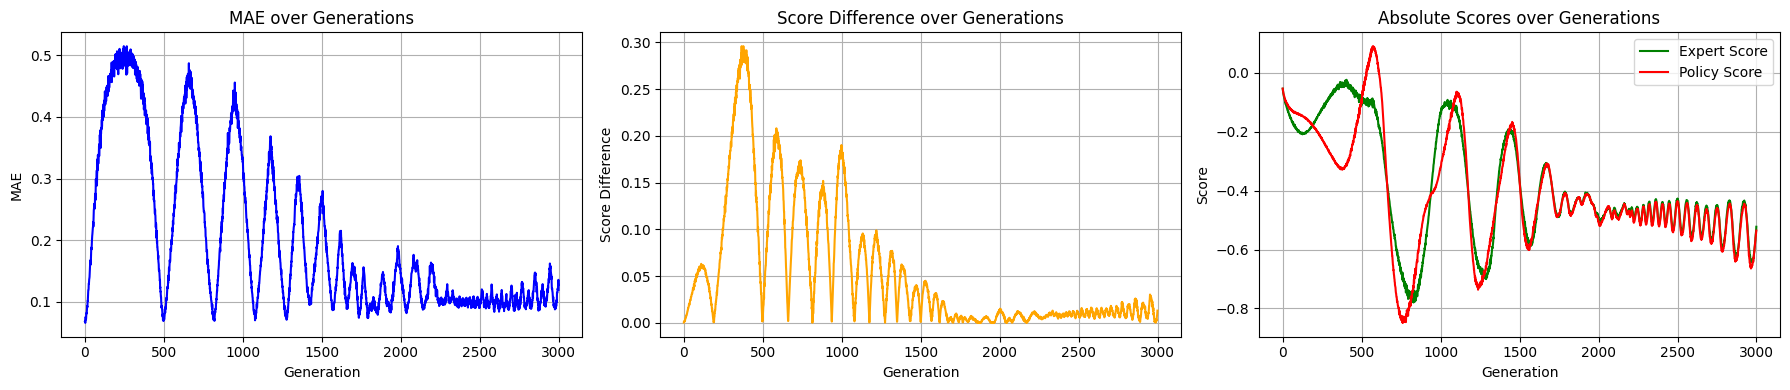

In [7]:
gens = np.arange(len(maes_list))

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True)

axes[0].plot(gens, maes_list, color="blue")
axes[0].set_xlabel("Generation")
axes[0].set_ylabel("MAE")
axes[0].set_title("MAE over Generations")
axes[0].grid(True)

axes[1].plot(gens, score_diffs, color="orange")
axes[1].set_xlabel("Generation")
axes[1].set_ylabel("Score Difference")
axes[1].set_title("Score Difference over Generations")
axes[1].grid(True)

abs_scores_arr = np.array(abs_scores)  # shape: [G, 2]
axes[2].plot(gens, abs_scores_arr[:, 0], color="green", label="Expert Score")
axes[2].plot(gens, abs_scores_arr[:, 1], color="red",  label="Policy Score")
axes[2].set_xlabel("Generation")

axes[2].set_ylabel("Score")
axes[2].set_title("Absolute Scores over Generations")
axes[2].legend()
axes[2].grid(True)
plt.tight_layout()
plt.show()